In [1]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import lightgbm as lgbww

## 1 - Prepare data

In [25]:
# 1)
# Get data
df = pd.read_csv(
    r'C:\Users\harri\ai_bobby_repository\data\raw\gelation_hardness_dec_2024.csv',
    dtype={
        'Treatment code': object,
        'Protein codes': object,
        'Type of salt': object,
        'Additives': object,
    }
)

# Get only rows with gel formation
#df = df[df['If a gel can be formed (0-1)'] == 1]


# Define categorical columns
categorical_columns = ['Protein codes', 'Type of salt', 'Additives', 'Treatment code']

# Define numeric columns
numerical_columns = [
    'Samples stored (°C)',
    'ionic strength (M)',
    'Additives Concentration (%)',
    'Protein Concentration (%)',
    'pH',
    'Heating temperature (°C) for gel preparation',
    'Heating/hold time (min)',
    'Hardness/firmness/strength (g)'
]

# Convert object columns to categorical
for col in categorical_columns:
    df[col] = df[col].astype('str')

# Convert columns to numeric
for col in numerical_columns:
    df[col] = df[col].astype('float64')

# Columns to drop
columns_to_drop = [
    'Citation',
    'Citation Link',
    'Protein',
    'Treatment condition code',
    'Treatment condition value',
    'Treatment temperature ( °C)',
    'Treatment time (min)',
    'Storage time (h)',
    'If a gel can be formed (0-1)',
]

# Drop columns
df_clean = df.drop(columns=columns_to_drop, axis=1)

# Drop rows with missing target values
df_clean = df_clean.dropna(subset=['Hardness/firmness/strength (g)'])

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Protein codes                                 1005 non-null   object 
 1   Protein Concentration (%)                     1005 non-null   float64
 2   Treatment code                                1005 non-null   object 
 3   Additives                                     1005 non-null   object 
 4   Additives Concentration (%)                   568 non-null    float64
 5   pH                                            863 non-null    float64
 6   Type of salt                                  1005 non-null   object 
 7   ionic strength (M)                            479 non-null    float64
 8   Heating temperature (°C) for gel preparation  867 non-null    float64
 9   Heating/hold time (min)                       867 non-null    f

In [ ]:
# 2)
# Charger les données
df = pd.read_csv(
    r"C:\Users\harri\Downloads\Hardness.csv", sep=';',
    dtype={
        'Treatment code': object,
        'Protein codes': object,
        'Type of salt': object,
    }
)

# Nettoyer les noms de colonnes (supprimer espaces, caractères invisibles)
df.columns = df.columns.str.strip()

# Afficher la liste des colonnes pour vérifier leur existence
print("Colonnes disponibles :", df.columns.tolist())

# Définir les colonnes catégoriques
categorical_columns = ['Protein codes', 'Type of salt', 'Additives', 'Treatment code']

# Définir les colonnes numériques
numerical_columns = [
    'Samples stored (°C)',
    'ionic strength (M)',
    'Additives Concentration (%)',
    'Protein Concentration (%)',
    'pH',
    'Heating temperature (°C) for gel preparation',
    'Heating/hold time (min)',
    'Hardness/firmness/strength (g)',
]

# Convertir les colonnes catégoriques en chaînes de caractères
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('str')
    else:
        print(f"Attention : La colonne '{col}' est absente du DataFrame.")

# Remplacer les virgules par des points et convertir les colonnes numériques en float
for col in numerical_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].replace(',', '.', regex=True), errors='coerce')
    else:
        print(f"Attention : La colonne '{col}' est absente du DataFrame.")

# Vérifier si certaines colonnes contiennent encore des valeurs manquantes après conversion
missing_values = df[numerical_columns].isna().sum()
print("Valeurs manquantes par colonne :", missing_values)

# Colonnes à supprimer
columns_to_drop = [
    'Citation',
    'Citation Link',
    'Protein',
    'Treatment condition code',
    'Treatment condition value',
    'Treatment temperature ( °C)',
    'Treatment time (min)',
    'Storage time (h)',
    'If a gel can be formed (0-1)',
]

# Supprimer les colonnes si elles existent
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df_clean_copy = df.drop(columns=columns_to_drop, axis=1)

# Supprimer les lignes avec des valeurs cibles manquantes
df_clean_copy = df_clean_copy.dropna(subset=['Hardness/firmness/strength (g)'])

# Afficher un aperçu des données finales
df_clean_copy.info()

Colonnes disponibles : ['Citation', 'Citation Link', 'Protein', 'Protein codes', 'Protein Concentration (%)', 'Treatment code', 'Treatment condition code', 'Treatment condition value', 'Treatment temperature ( °C)', 'Treatment time (min)', 'Additives', 'Additives Concentration (%)', 'pH', 'Type of salt', 'ionic strength (M)', 'Heating temperature (°C) for gel preparation', 'Heating/hold time (min)', 'Samples stored (°C)', 'Storage time (h)', 'If a gel can be formed (0-1)', 'Hardness/firmness/strength (g)', 'Unnamed: 21']
Valeurs manquantes par colonne : Samples stored (°C)                             105
ionic strength (M)                              515
Additives Concentration (%)                     412
Protein Concentration (%)                         0
pH                                              207
Heating temperature (°C) for gel preparation    169
Heating/hold time (min)                         169
Hardness/firmness/strength (g)                    0
dtype: int64
<class 'pan

In [44]:
# 1075 entrées pour le GelHardness
df_clean_copy.shape

(1074, 13)

### Transform target variable
- Soft gel = 0 to 1000 grams (upto 10 Newtons)
- Firm gel = 1000 to 5000 grams (50 Newtons)
- Rigid gel/stable gel = 5000 to- 1,000,000 grams (upto 200 Newtons)


In [46]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Suppression des colonnes inutiles comme 'Unnamed: 21'
df_clean_copy = df_clean_copy.drop(columns=['Unnamed: 21'], errors='ignore')

# Sélectionner les colonnes numériques et catégorielles
numerical_cols = df_clean_copy.select_dtypes(include=np.number).columns
categorical_cols = df_clean_copy.select_dtypes(include=['object']).columns

# Nettoyage des données avant l'entraînement
df_clean_copy = df_clean_copy.copy()

# Remplacer les espaces vides par NaN dans les colonnes catégorielles
df_clean_copy[categorical_cols] = df_clean_copy[categorical_cols].replace(' ', np.nan)

# Remplacer les virgules par des points et nettoyer les caractères non numériques dans les colonnes numériques
for col in numerical_cols:
    # Remplacer les virgules par des points
    df_clean_copy[col] = df_clean_copy[col].replace({',': '.'}, regex=True)
    # Supprimer les caractères non numériques (en dehors des points décimaux)
    df_clean_copy[col] = df_clean_copy[col].replace(r'[^0-9.-]', '', regex=True)

# Convertir les colonnes numériques en type float64, gérer les erreurs de conversion
df_clean_copy[numerical_cols] = df_clean_copy[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Imputation des valeurs manquantes pour les colonnes numériques avec la médiane
imputer_num = SimpleImputer(strategy='median')
df_clean_copy[numerical_cols] = imputer_num.fit_transform(df_clean_copy[numerical_cols])

# Imputation des valeurs manquantes pour les colonnes catégorielles avec la modalité la plus fréquente
imputer_cat = SimpleImputer(strategy='most_frequent')
df_clean_copy[categorical_cols] = imputer_cat.fit_transform(df_clean_copy[categorical_cols])

# Vérification des types après nettoyage
print(df_clean_copy.dtypes)

# Préparation du pipeline avec prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_cols),  # Imputation numérique
        ('cat', SimpleImputer(strategy='most_frequent'), categorical_cols)  # Imputation catégorielle
    ])

# Exemple d'utilisation d'un pipeline avec prétraitement
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())  # Ajoutez ici le modèle ou d'autres étapes selon le cas
])

# Appliquer le pipeline sur les données nettoyées
X_processed = pipeline.fit_transform(df_clean_copy)


Protein codes                                    object
Protein Concentration (%)                       float64
Treatment code                                   object
Additives                                        object
Additives Concentration (%)                     float64
pH                                              float64
Type of salt                                     object
ionic strength (M)                              float64
Heating temperature (°C) for gel preparation    float64
Heating/hold time (min)                         float64
Samples stored (°C)                             float64
Hardness/firmness/strength (g)                  float64
dtype: object


In [47]:
def categorize_gel_strength(dataframe: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Categorizes a continuous column into gel strength categories.

    Parameters:
    dataframe (pd.DataFrame): Input DataFrame.
    column_name (str): Name of the column to be transformed.

    Returns:
    pd.DataFrame: DataFrame with a new column `<column_name>_category` containing the categories.
    """
    # Define the bins and labels
    bins = [0, 1000, 5000, 1000000]
    labels = [0, 1, 2] # Soft, Firm, Rigid

    # Create a new column for the categories
    category_column_name = f"{column_name}_category"
    dataframe[category_column_name] = pd.cut(
        dataframe[column_name], bins=bins, labels=labels, include_lowest=True
    )

    return dataframe

In [48]:
df_clean_copy = categorize_gel_strength(df_clean_copy, 'Hardness/firmness/strength (g)')
df_clean_copy.head()

,Protein codes,Protein Concentration (%),Treatment code,Additives,Additives Concentration (%),pH,Type of salt,ionic strength (M),Heating temperature (°C) for gel preparation,Heating/hold time (min),Samples stored (°C),Hardness/firmness/strength (g),Hardness/firmness/strength (g)_category
0,10501,12.0,nan,nan,0.6,5.0,nan,0.03,90.0,30.0,4.0,131.91,0
1,10501,12.0,nan,80203,0.5,5.0,nan,0.03,90.0,30.0,4.0,155.91,0
2,10501,12.0,nan,80203,1.0,5.0,nan,0.03,90.0,30.0,4.0,151.14,0
3,10501,12.0,nan,80203,2.0,5.0,nan,0.03,90.0,30.0,4.0,144.84,0
4,10501,12.0,nan,nan,0.6,6.0,nan,0.03,90.0,30.0,4.0,95.71,0


In [49]:
df_clean_copy.drop(columns=['Hardness/firmness/strength (g)'], inplace=True)

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_evaluate_model(X, y, k=5, model=Pipeline(steps=[]), 
                            metrics_list=[accuracy_score, precision_score, recall_score, f1_score], 
                            numerical_cols=None, categorical_cols=None):
  """
  Trains and evaluates a classification model using K-fold cross-validation.

  Args:
    X: The feature matrix.
    y: The target variable.
    k: The number of folds for cross-validation.
    model: The classification model to use (must be a Pipeline if preprocessing is needed).
    metrics_list: A list of metric functions to evaluate the model.
    numerical_cols: List of numerical column names (needed for preprocessing).
    categorical_cols: List of categorical column names (needed for preprocessing).

  Returns:
    A dictionary of evaluation results for each fold and the average across all folds.
  """

  kf = KFold(n_splits=k, shuffle=True, random_state=42)
  results = []

  for _, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_df = pd.DataFrame(X_train, columns=numerical_cols.tolist() + categorical_cols.tolist())
    X_test_df = pd.DataFrame(X_test, columns=numerical_cols.tolist() + categorical_cols.tolist())
    model.fit(X_train_df, y_train)  # Fit with DataFrame
    y_pred = model.predict(X_test_df)  # Predict with DataFrame

    fold_results = {}
    for metric in metrics_list:
      metric_name = metric.__name__
      if metric_name in ['precision_score', 'recall_score', 'f1_score']:
        fold_results[metric_name] = metric(y_test.codes, y_pred, average='weighted')
      else:
        fold_results[metric_name] = metric(y_test.codes, y_pred)
    results.append(fold_results)

  # Calculate average results across all folds
  avg_results = {}
  for metric_name in results[0].keys():
    avg_results[metric_name] = np.mean([fold[metric_name] for fold in results])

  return avg_results

In [51]:
df_clean_copy['Hardness/firmness/strength (g)_category'].value_counts()

Hardness/firmness/strength (g)_category
0    929
1     95
2     50
Name: count, dtype: int64

In [52]:
df_clean_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 12 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   Protein codes                                 1074 non-null   object  
 1   Protein Concentration (%)                     1074 non-null   float64 
 2   Treatment code                                1074 non-null   object  
 3   Additives                                     1074 non-null   object  
 4   Additives Concentration (%)                   1074 non-null   float64 
 5   pH                                            1074 non-null   float64 
 6   Type of salt                                  1074 non-null   object  
 7   ionic strength (M)                            1074 non-null   float64 
 8   Heating temperature (°C) for gel preparation  1074 non-null   float64 
 9   Heating/hold time (min)                       1074 n

In [53]:
X = df_clean_copy.drop('Hardness/firmness/strength (g)_category', axis=1)
y = df_clean_copy['Hardness/firmness/strength (g)_category']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
    ])

## 2 - Train models

In [54]:
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import lightgbm as lgb
from warnings import filterwarnings
filterwarnings('ignore')

RANDOM_STATE = 42

models = {
    "Dummy Classifier": Pipeline(steps=[('classifier', DummyClassifier(strategy='most_frequent'))]),
    "Logistic Regression": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))]),
    "Decision Tree": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))]),
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))]),
    "LightGBM": Pipeline(steps=[('preprocessor', preprocessor), ('classifier', lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, verbose_eval=False, class_weight='balanced',n_jobs=1))]),
}

all_results = {}

for model_name, model in tqdm(models.items()):
    print(f"Training {model_name}...")
    avg_results = train_and_evaluate_model(
        X.values, y.values, model=model, 
        numerical_cols=numerical_cols, 
        categorical_cols=categorical_cols,
    )
    all_results[model_name] = avg_results


  0%|          | 0/5 [00:00<?, ?it/s]

Training Dummy Classifier...
Training Logistic Regression...


 60%|██████    | 3/5 [00:00<00:00,  7.38it/s]

Training Decision Tree...
Training Random Forest...


 80%|████████  | 4/5 [00:01<00:00,  2.05it/s]

Training LightGBM...


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


In [55]:

results_df = pd.DataFrame(all_results).T
print("\nSummary of Results:")
results_df.sort_values(by='f1_score', ascending=False).head(20)



Summary of Results:


,accuracy_score,precision_score,recall_score,f1_score
LightGBM,0.953441,0.954137,0.953441,0.953410
Random Forest,0.955305,0.953700,0.955305,0.953248
Decision Tree,0.944134,0.944737,0.944134,0.943635
Dummy Classifier,0.864982,0.748620,0.864982,0.802490
Logistic Regression,0.632263,0.850404,0.632263,0.701240


## 3 - Get feature importance for CatBoost Model (best model)

In [78]:
from sklearn.model_selection import train_test_split

catboost_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
catboost_model.fit(X_train, y_train, cat_features=list(categorical_cols))

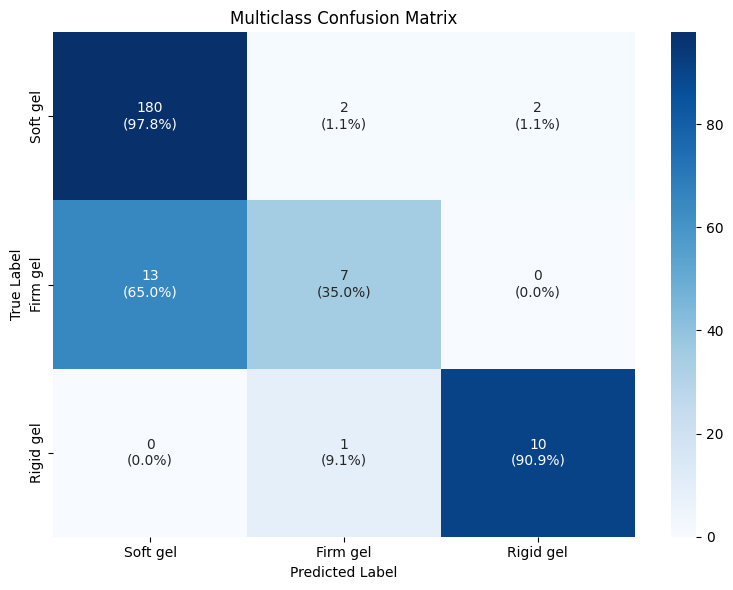

In [79]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Class labels
class_names = ["Soft gel", "Firm gel", "Rigid gel"]

# Compute confusion matrix
cm = confusion_matrix(y_test, catboost_model.predict(X_test))  # Raw counts
cm_normalized = confusion_matrix(y_test, catboost_model.predict(X_test), normalize='true')  # Normalize by row to get percentages

# Convert to percentage and format as string
cm_percentage = cm_normalized * 100
cm_labels = np.array([f"{count}\n({value:.1f}%)" for count, value in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=cm_labels, fmt='', cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add title and labels
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [80]:
catboost_ypred = catboost_model.predict(X_test)
print(f1_score(y_test, catboost_ypred, average='weighted'))


0.905123109286144


In [81]:
catboost_ypred = catboost_model.predict(X_test)
print(accuracy_score(y_test, catboost_ypred))

0.9162790697674419


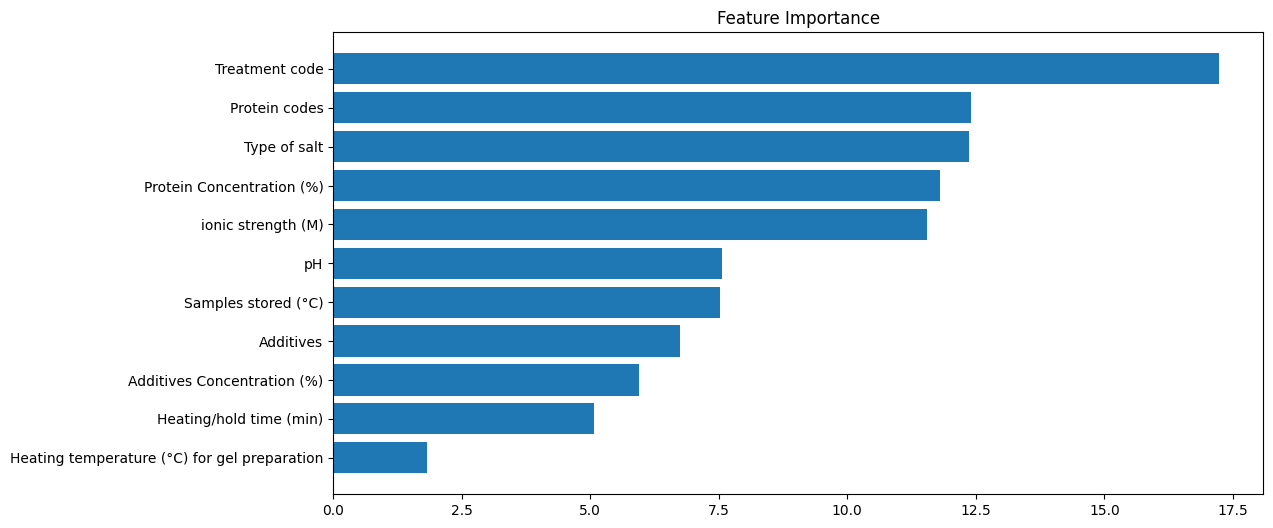

In [82]:
from matplotlib import pyplot as plt

feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

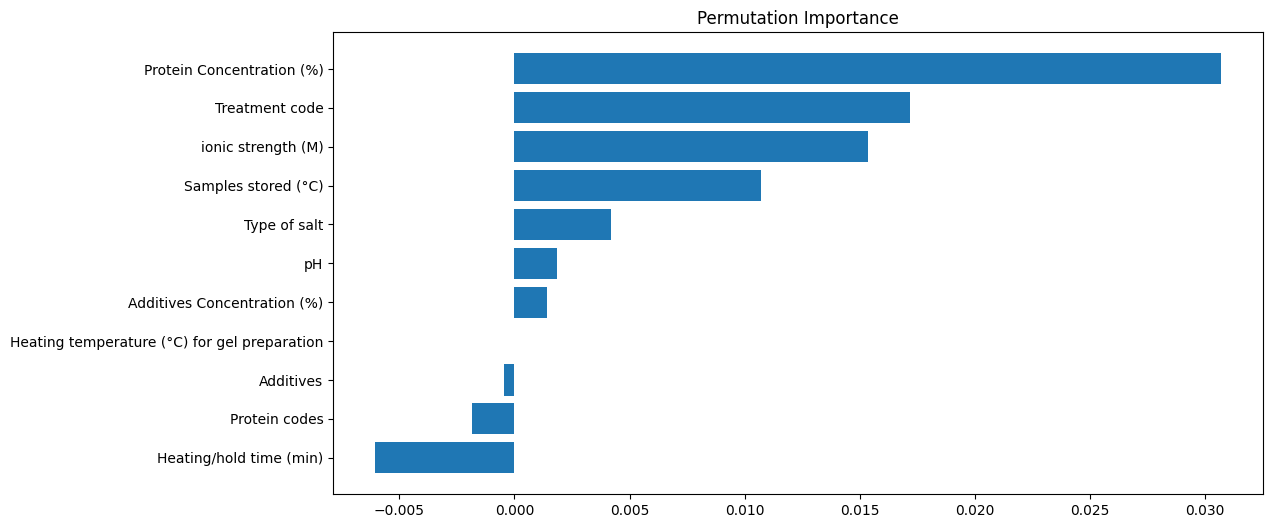

In [83]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(catboost_model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')
plt.show()

**VOTING CLASSIFIER FOR OUR THREE BEST MODELS**

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

In [89]:
# Données d'exemple
# Supposons que X et y soient vos features et labels respectifs
# Encodage des variables catégoriques
X_clean = pd.get_dummies(X, drop_first=True)

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

# Définition des modèles de base
random_forest = RandomForestClassifier(random_state=42)
catboost = CatBoostClassifier(random_state=42, verbose=0)
light_gbm = LGBMClassifier(random_state=42)

# Définition du VotingClassifier
voting_classifier = VotingClassifier(estimators=[
    ('rf', random_forest),  
    ('ct', catboost),
    ('lgb', light_gbm)
], voting='hard')

# Définir un espace de recherche pour GridSearchCV
param_grid = {
    # Hyperparamètres pour RandomForest
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    
    # Hyperparamètres pour CatBoost
    'ct__iterations': [100, 200],
    'ct__learning_rate': [0.01, 0.1],
    
    # Hyperparamètres pour LGBM
    'lgb__num_leaves': [31, 50],
    'lgb__learning_rate': [0.01, 0.1],
}

# GridSearchCV
grid_search = GridSearchCV(estimator=voting_classifier, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=1, n_jobs=-1)

# Entraînement
grid_search.fit(X_train, y_train)

# Résultats
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleure précision :", grid_search.best_score_)



Fitting 3 folds for each of 96 candidates, totalling 288 fits
Meilleurs paramètres : {'ct__iterations': 100, 'ct__learning_rate': 0.01, 'lgb__learning_rate': 0.01, 'lgb__num_leaves': 31, 'rf__max_depth': None, 'rf__n_estimators': 100}
Meilleure précision : nan


In [90]:
# Prédiction sur l'ensemble de test
best_voting_classifier = grid_search.best_estimator_
y_pred = best_voting_classifier.predict(X_test)
print("Précision sur l'ensemble de test :", accuracy_score(y_test, y_pred))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 215) + inhomogeneous part.

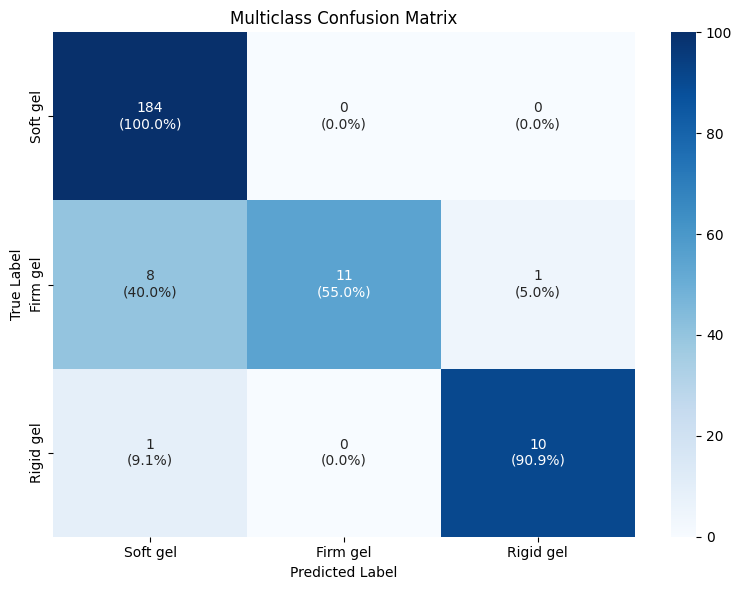

In [74]:
# Class labels
class_names = ["Soft gel", "Firm gel", "Rigid gel"]

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row to get percentages

# Convert to percentage and format as string
cm_percentage = cm_normalized * 100
cm_labels = np.array([f"{count}\n({value:.1f}%)" for count, value in zip(cm.flatten(), cm_percentage.flatten())]).reshape(cm.shape)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=cm_labels, fmt='', cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add title and labels
plt.title("Multiclass Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
